# An RNN for short-term predictions
This model will try to predict the next value in a short sequence based on historical data. This can be used for example to forecast demand based on a couple of weeks of sales data.

<div class="alert alert-block alert-info">
Things to do:<br/>
<ol start="0">
<li> Run the notebook. Initially it uses a linear model (the simplest one). Look at the RMSE (Root Means Square Error) metrics at the end of the training and how they compare against a couple of simplistic models: random predictions (RMSErnd), predict same as last value (RMSEsal), predict based on trend from two last values (RMSEtfl).
<li> Now implement the DNN (Dense Neural Network) model [here](#assignment1) using `tf.layers.dense`. See how it performs.
<li> Swap in the CNN (Convolutional Neural Network) model [here](#assignment2). It is already implemented in function CNN_model. See how it performs.
<li> Implement the RNN model [here](#assignment3) using a single `tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)`. See how it performs.
<li> Make the RNN cell 2-deep [here](#assignment4) using `tf.nn.rnn_cell.MultiRNNCell`. See if this improves things. Try also training for 10 epochs instead of 5.
<li> You can now go and check out the solutions in file [00_RNN_predictions_solution.ipynb](00_RNN_predictions_solution.ipynb). It's final cell has a loop that benchmarks all the neural network architectures. Try it and then if you have the time, try reducing the data sequence length from 16 to 8 (SEQLEN=8) and see if you can still predict the next value with so little context.
</ol>
</div>

In [1]:
import numpy as np
import utils_datagen
import utils_display
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


## Generate fake dataset

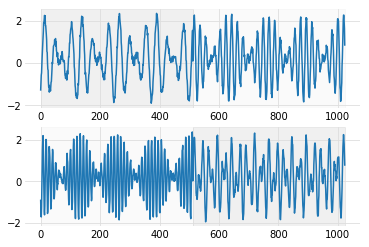

In [2]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([utils_datagen.create_time_series(waveform, DATA_SEQ_LEN) for waveform in utils_datagen.Waveforms])
utils_display.picture_this_1(data, DATA_SEQ_LEN)

## Hyperparameters

In [3]:
RNN_CELLSIZE = 32    # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

## Visualize training sequences
This is what the neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


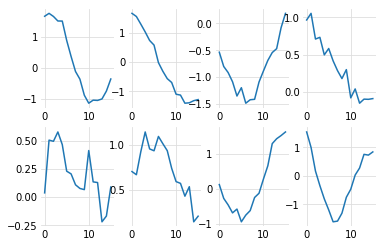

In [7]:
utils_display.picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [8]:
# tree simplistic predictive models: can you beat them ?
def simplistic_models(X):
    # "random" model
    Yrnd = tf.random_uniform([tf.shape(X)[0]], -2.0, 2.0) # tf.shape(X)[0] is the batch size
    # "same as last" model
    Ysal = X[:,-1]
    # "trend from last two" model
    Ytfl = X[:,-1] + (X[:,-1] - X[:,-2])
    return Yrnd, Ysal, Ytfl

In [9]:
# linear model (RMSE: 0.36, with shuffling: 0.17)
def linear_model(X):
    Yout = tf.layers.dense(X, 1) # output shape [BATCHSIZE, 1]
    return Yout

<a name="assignment1"></a>
<div class="alert alert-block alert-info">
**Assignment #1**: Implement the DNN (Dense Neural Network) model using a single `tf.layers.dense` layer. Do not forget to use the DNN_model function when [instantiating the model](#instantiate)
</div>

In [10]:
# 2-layer dense model (RMSE: 0.38, with shuffling: 0.15-0.18)
def DNN_model(X):
    Y = tf.layers.dense(X, SEQLEN //2, activation=tf.nn.relu)
    Yout = tf.layers.dense(Y, 1, activation=None) # output shape [BATCHSIZE, 1]
    return Yout

<a name="assignment2"></a>
<div class="alert alert-block alert-info">
**Assignment #2**: Swap in the CNN (Convolutional Neural Network) model. It is already implemented in function CNN_model below so all you have to do is read through the CNN_model code and then use the DNN_model function when [instantiating the model](#instantiate).
</div>

In [11]:
# convolutional (RMSE: 0.31, with shuffling: 0.16)
def CNN_model(X):
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    Y = tf.layers.conv1d(X, filters=8, kernel_size=4, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=16, kernel_size=3, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=1, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=3, activation=tf.nn.relu, padding="same")  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    Yout = tf.layers.conv1d(Y, filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid") # output shape [BATCHSIZE, 1, 1]
    Yout = tf.squeeze(Yout, axis=-1) # output shape [BATCHSIZE, 1]
    return Yout

<a name="assignment3"></a>
<div class="alert alert-block alert-info">
**Assignment #3**: Implement the RNN (Recurrent Neural Network) model using `tf.layers.dense`. Do not forget to use the RNN_model_N function when [instantiating the model](#instantiate).</div>

<a name="assignment4"></a>
<div class="alert alert-block alert-info">
**Assignment #4**: Make the RNN cell 2-deep [here](#assignment2) using `tf.nn.rnn_cell.MultiRNNCell`. See if this improves things. Try also training for 10 epochs instead of 5. Finally try to compute the loss on the last n elemets of the predicted sequence instead of the last (n=SEQLEN//2 for example). Do not forget to use the RNN_model_N function when [instantiating the model](#instantiate).
</div>

In [12]:
# RNN model (RMSE: 0.38, with shuffling 0.14, the same with loss on last 8)
def RNN_model(X, n=1):
    # 2-layer RNN
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for i in range(2)]
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    batchsize = tf.shape(X)[0]
    Yn = tf.reshape(Yn, [batchsize * SEQLEN, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, SEQLEN, 1])   # Yr [BATCHSIZE, SEQLEN, 1]
    
    # In this RNN model, you can compute the loss on the last predicted item or the last n predicted items
    # Last n with n=SEQLEN//2 is slightly better. This is a hyperparameter you can adjust in the RNN_model_N
    # function below.
    Yout = Yr[:,-n:SEQLEN,:] # last item(s) in sequence: output shape [BATCHSIZE, n, 1]
    Yout = tf.squeeze(Yout, axis=-1)
    return Yout

In [14]:
def RNN_model_N(X):
    return RNN_model(X, n=SEQLEN // 2)

In [15]:
def model_fn(features, labels, model):
    X = features # shape [BATCHSIZE, SEQLEN]
    
    Y = model(X)

    last_label = labels[:, -1] # last item in sequence: the target value to predict
    last_labels = labels[:, -tf.shape(Y)[1]:SEQLEN] # last p items in sequence (as many as in Y), useful for RNN_model(X, n>1)

    loss = tf.losses.mean_squared_error(Y, last_labels) # loss computed on last label(s)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    Yrnd, Ysal, Ytfl = simplistic_models(X)
    eval_metrics = {"RMSE": tf.sqrt(loss),
                    # compare agains three simplistic predictive models: can you beat them ?
                    "RMSErnd": tf.sqrt(tf.losses.mean_squared_error(Yrnd, last_label)),
                    "RMSEsal": tf.sqrt(tf.losses.mean_squared_error(Ysal, last_label)),
                    "RMSEtfl": tf.sqrt(tf.losses.mean_squared_error(Ytfl, last_label))}
    
    Yout = Y[:,-1]
    return Yout, loss, eval_metrics, train_op

# prepare training dataset

In [16]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)
# slice data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# also make an evaluation dataset by randomly subsampling our fake data
EVAL_SEQUENCES = DATA_SEQ_LEN*4//SEQLEN//4
joined_data = np.stack([traindata, labeldata], axis=1) # new shape is [N_sequences, 2(train/eval), SEQLEN]
joined_evaldata = joined_data[np.random.choice(joined_data.shape[0], EVAL_SEQUENCES, replace=False)]
evaldata = joined_evaldata[:,0,:]
evallabels = joined_evaldata[:,1,:]

def datasets(nb_epochs):
    # Dataset API for batching, shuffling, repeating
    dataset = tf.data.Dataset.from_tensor_slices((traindata, labeldata))
    dataset = dataset.repeat(NB_EPOCHS)
    dataset = dataset.shuffle(DATA_SEQ_LEN*4//SEQLEN) # important ! Number of sequences in shuffle buffer: all of them
    dataset = dataset.batch(BATCHSIZE)
    
    # Dataset API for batching
    evaldataset = tf.data.Dataset.from_tensor_slices((evaldata, evallabels))
    evaldataset = evaldataset.repeat()
    evaldataset = evaldataset.batch(EVAL_SEQUENCES) # just one batch with everything

    # Some boilerplate code...
    
    # this creates a Tensorflow iterator of the correct type and shape
    # compatible with both our training and eval datasets
    tf_iter = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
    # it can be initialized to iterate through the training dataset
    dataset_init_op = tf_iter.make_initializer(dataset)
    # or it can be initialized to iterate through the eval dataset
    evaldataset_init_op = tf_iter.make_initializer(evaldataset)
    # Returns the tensorflow nodes needed by our model_fn.
    samples, labels = tf_iter.get_next()
    # When these nodes will be executed (sess.run) in the training or eval loop,
    # they will output the next batch of data.

    # Note: when you do not need to swap the dataset (like here between train/eval) just use
    # samples, labels = dataset.make_one_shot_iterator().get_next()
    # TODO: easier with tf.estimator.inputs.numpy_input_fn ???
    
    return samples, labels, dataset_init_op, evaldataset_init_op

<a name="instantiate"></a>
## Instantiate the model

In [17]:
NB_EPOCHS = 10

# instantiate the dataset
samples, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
# instantiate the model
Yout, loss, eval_metrics, train_op = model_fn(samples, labels, linear_model)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [18]:
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## The training loop
You can re-execute this cell to continue training

In [19]:
count = 0
losses = []
indices = []
sess.run(dataset_init_op)
while True:
    try: loss_, _ = sess.run([loss, train_op])
    except tf.errors.OutOfRangeError: break
    # print progress
    if count%300 == 0:
        epoch = count // (DATA_SEQ_LEN*4//BATCHSIZE//SEQLEN)
        print("epoch " + str(epoch) + ", batch " + str(count) + ", loss=" + str(loss_))
    if count%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(count)
    count += 1
    
# final evaluation
sess.run(evaldataset_init_op)
eval_metrics_, Yout_ = sess.run([eval_metrics, Yout])
print("Final accuracy on eval dataset:")
print(str(eval_metrics_))

epoch 0, batch 0, loss=5.01892
epoch 0, batch 300, loss=0.040965013
epoch 0, batch 600, loss=0.064044245
epoch 0, batch 900, loss=0.06104378
epoch 1, batch 1200, loss=0.05918147
epoch 1, batch 1500, loss=0.048460558
epoch 1, batch 1800, loss=0.04000219
epoch 2, batch 2100, loss=0.039410785
epoch 2, batch 2400, loss=0.044643406
epoch 2, batch 2700, loss=0.043808617
epoch 2, batch 3000, loss=0.038612008
epoch 3, batch 3300, loss=0.051851556
epoch 3, batch 3600, loss=0.052146986
epoch 3, batch 3900, loss=0.054418594
epoch 4, batch 4200, loss=0.054717127
epoch 4, batch 4500, loss=0.05131403
epoch 4, batch 4800, loss=0.0322199
epoch 4, batch 5100, loss=0.049768686
epoch 5, batch 5400, loss=0.04560277
epoch 5, batch 5700, loss=0.051002625
epoch 5, batch 6000, loss=0.05894602
epoch 6, batch 6300, loss=0.045409936
epoch 6, batch 6600, loss=0.03356533
epoch 6, batch 6900, loss=0.076470286
epoch 7, batch 7200, loss=0.06970079
epoch 7, batch 7500, loss=0.041347615
epoch 7, batch 7800, loss=0.0441

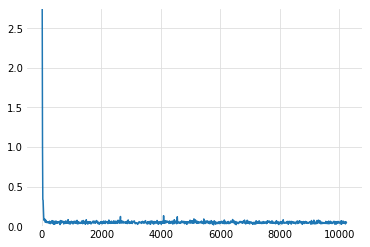

In [20]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value(s) for scaling
plt.plot(indices, losses)
plt.show()

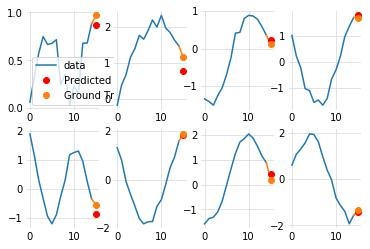

In [21]:
# execute multiple times to see different sample sequences
utils_display.picture_this_3(Yout_, evaldata, evallabels, SEQLEN)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.